This is a Julian fork of the 12 steps to Navier-Stokes (Python) [https://github.com/barbagroup/CFDPython] by Lorena A. Barba, Gilbert F. Forsyth . All content of that work is under Creative Commons Attribution CC-BY 4.0, and all python code is under BSD-3 clause. This work also derives from similar forks by Cysor [https://github.com/Cysor/CFDJulia] and by Wallace-dyfq [https://github.com/Wallace-dyfq/CFD-Julia-12-steps--o-Navier-Stokes-Equations]

For a moment, recall the Navier-Stokes equations for an incompressible fluid, where $\vec{v}$ represents the velocity field:

\begin{eqnarray}
\nabla \cdot\vec{v} &=& 0\\\
\frac{\partial \vec{v}}{\partial t}+(\vec{v}\cdot\nabla)\vec{v} &=& -\frac{1}{\rho}\nabla p + \nu \nabla^2\vec{v}
\end{eqnarray}

The first equation represents mass conservation at constant density. The second equation is the conservation of momentum. But a problem appears: the continuity equation for incompressble flow does not have a dominant variable and there is no obvious way to couple the velocity and the pressure. In the case of compressible flow, in contrast, mass continuity would provide an evolution equation for the density $\rho$, which is coupled with an equation of state relating $\rho$ and $p$.

In incompressible flow, the continuity equation $\nabla \cdot\vec{v}=0$ provides a *kinematic constraint* that requires the pressure field to evolve so that the rate of expansion $\nabla \cdot\vec{v}$ should vanish everywhere. A way out of this difficulty is to *construct* a pressure field that guarantees continuity is satisfied; such a relation can be obtained by taking the divergence of the momentum equation. In that process, a Poisson equation for the pressure shows up!

Step 10: 2D Poisson Equation
----
***

Poisson's equation is obtained from adding a source term to the right-hand-side of Laplace's equation:

$$\frac{\partial ^2 p}{\partial x^2} + \frac{\partial ^2 p}{\partial y^2} = b$$

So, unlinke the Laplace equation, there is some finite value inside the field that affects the solution. Poisson's equation acts to "relax" the initial sources in the field.

In discretized form, this looks almost the same as Step 9, except for the source term:

$$\frac{p_{i+1,j}^{n}-2p_{i,j}^{n}+p_{i-1,j}^{n}}{\Delta x^2}+\frac{p_{i,j+1}^{n}-2 p_{i,j}^{n}+p_{i,j-1}^{n}}{\Delta y^2}=b_{i,j}^{n}$$

As before, we rearrange this so that we obtain an equation for $p$ at point $i,j$. Thus, we obtain:

$$p_{i,j}^{n}=\frac{(p_{i+1,j}^{n}+p_{i-1,j}^{n})\Delta y^2+(p_{i,j+1}^{n}+p_{i,j-1}^{n})\Delta x^2-b_{i,j}^{n}\Delta x^2\Delta y^2}{2(\Delta x^2+\Delta y^2)}$$


We will solve this equation by assuming an initial state of $p=0$ everywhere, and applying boundary conditions as follows:

$p=0$ at $x=0, \ 2$ and $y=0, \ 1$

and the source term consists of two initial spikes inside the domain, as follows:

$b_{i,j}=100$ at $i=\frac{1}{4} nx, j=\frac{1}{4} ny$

$b_{i,j}=-100$ at $i=\frac{3}{4} nx, j=\frac{3}{4} ny$

$b_{i,j}=0$ everywhere else.

The iterations will advance in pseudo-time to relax the initial spikes. The relaxation under Poisson's equation gets slower and slower as they progress. *Why?*

Let's look at one possible way to write the code for Poisson's equation. Let's get our parameters defined and the initialization out of the way. What do you notice of the approach below?

In [1]:
using Plots


nx = 50
ny = 50

xmin = 0.0
xmax = 2.0

ymin = 0.0
ymax = 1.0

    
Δx = (xmax - xmin) / (nx - 1)
Δy = (ymax - ymin) / (ny - 1)
    

x = range(xmin, stop=xmax, length=nx)
y = range(ymin, stop=ymax, length=ny)

p₀ = zeros(ny, nx)

b = zeros(ny, nx)

b[Int(floor(ny/4)),Int(floor(nx/4))]  = 100;
b[Int(floor(3*ny/4)),Int(floor(3*nx/4))] = -100;


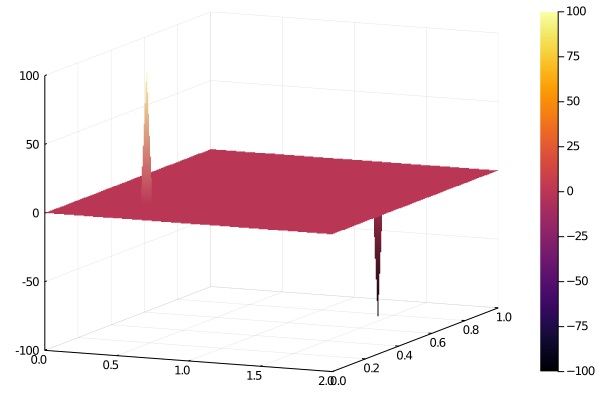

In [2]:
surface(x, y, b)

With that, we are ready to advance the initial guess in pseudo-time. How is the code below different from the function used in Step 9 to solve Laplace's equation?

In [3]:
using LinearAlgebra

function laplace2d_pseudotime(p₀, b, x, y, Δx, Δy; nt = 100, l1norm_target = 0.01)
      
    
    p = zeros(size(p₀));
    pn = similar(p)
    
    p .= p₀
    
    row = size(y,1)
    col = size(x,1)
    
    l1norm = 1;
    it = 1;
    
    while (l1norm > l1norm_target && it < nt)
    #for it in 1:nt
        
        pn .= p
                
        for j in 1:row
            for i in 1:col
                if j == 1
                    p[j,i] = 0.0
                elseif j == row
                    p[j,i] = 0.0
                elseif i == col
                    p[j,i] = 0.0
                elseif i == 1
                    p[j,i] = 0.0
                else
                    p[j,i] = ( Δy^2*(pn[j, i+1] + pn[j, i-1]) + Δx^2*(pn[j+1, i] + pn[j-1, i]) -b[j,i]*Δx^2*Δy^2 ) 
                        /2.0/ (Δx^2 + Δy^2)
                end
            end
        end
           
        l1norm = norm((p-pn)./(pn.+1.0e-30),1)
        
        it +=1;
        
    end
    
    @show it, l1norm
    
    return p

end

laplace2d_pseudotime (generic function with 1 method)

In [4]:
p = laplace2d_pseudotime(p₀, b, x, y, Δx, Δy; nt = 10000, l1norm_target = 0.001);

(it, l1norm) = (3906, 0.0009985431198974086)


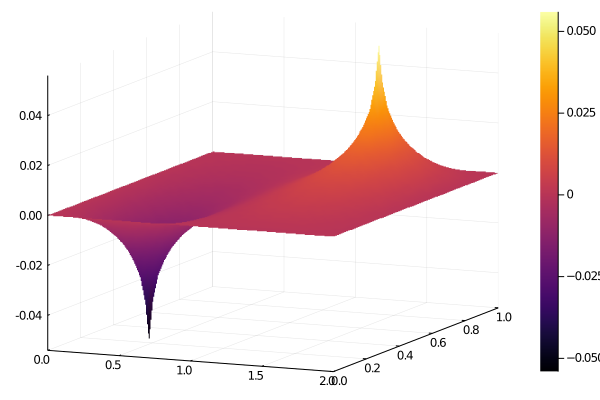

In [5]:
surface(x, y, p)